## Text Data and Recurring Neural Networks

In [2]:
source("src//lib.R")

In this notebook we'll summarise two related and important topics in Neural Networks:
* Text processing and how to feed text data into Neural Networks
* The Neural Networks models that have been developed to handle data having a sequence structure (i.e. text or timeseries)

### Text vectorization
In the previous notebooks we have seen that neural networks model must be fed with numeric tensors, the *text vectorization* is a process that transforms text data into quantitative data.

There are different way to *vectorize* text data, as example:
* Segment text into **words** and associate each word to a numerical vector.
* Segment text into **characters** and transform each character into a numerical vector.
* Extract **N-Grams** of words/characters and transform each N-Gram into a vector. A **N-gram** is a sequence of at most **N** consecutive words/characters in a text data: consider text *"UniCredit is a pan European Winner"*, it contains the following **3 grams**: *Unicredit, is, a, pan, European, Winner, Unicredit is, is a, a pan, pan European, European Winner, Unicredit is a, is a pan, a pan European, pan European Winner*.

In the following we'll focus our attention on the first *vectorization* strategy: **words** vectorization.

The **first step** in this process is to segment text data into words: *Tokenization*. Let's see how to tokenize text data in **KERAS**:

In [2]:
samples <- c("UniCredit is a pan European Winner", "CIB is fully plugged into UniCredit")
tokenizer <- text_tokenizer() %>%
 fit_text_tokenizer(samples)

tokenizer$word_counts %>% names

[1] "unicredit" "is"        "a"         "pan"       "european"  "winner"   
 [7] "cib"       "fully"     "plugged"   "into"

The tokenizer found 10 different *words* in the input sentences.

#### One-Hot encoding
Now we have to associate to these words (*tokens*) a numeric vector, the more simple way is called **One-Hot encoding**.

This encoding strategy first requires to associates a unique integer index id $H_w$ to each word $w$. In **KERAS** this is done directly by the *tokenizer*:

In [3]:
tokenizer$word_index

$unicredit
[1] 1

$is
[1] 2

$a
[1] 3

$pan
[1] 4

$european
[1] 5

$winner
[1] 6

$cib
[1] 7

$fully
[1] 8

$plugged
[1] 9

$into
[1] 10

Then we need to transform our sample sentences into list of indices:

In [4]:
sequences <- texts_to_sequences(tokenizer, samples)
class(sequences)

[1] "list"

The sequence associated with *UniCredit is a pan European Winner* is:

In [5]:
sequences[[1]]

[1] 1 2 3 4 5 6

The sequence associated with *CIB is fully plugged into UniCredit* is:

In [6]:
sequences[[2]]

[1]  7  2  8  9 10  1

Note that the two words *UniCredit* (coded by **1**) and *is* (coded by **2**) are the only ones contained in both sentences, and as a consequence their codes are repeated in both sequences.

**Finally** we need to transform each number into a binary vector $N$-dimensional binary vector (where $N$ is the number of unique words in all the sentences) in which the only not-zero component is the one corresponding to the given number. This final step is currently done by **KERAS** in a more smart way (as we'll see soon), btw here is a simple base *R* code to do compute this final step:

In [7]:
results <- array(0, dim = c(
  length(sequences), # number of sentences
  max(sapply(sequences, length)), # maximum number of words in a sentence
  max(sapply(sequences, max)) # number of unique words in all sentences
))

for (i in 1:length(sequences)) {
  sequence <- sequences[[i]]
  for(h in 1:length(sequence)) {
    results[i, h, sequence[h]] <- 1
  }
}

The first sentences is **one-hot encoded** by:

In [8]:
results[1,,]

1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0


And the second one by:

In [9]:
results[2,,]

0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0


#### Words Embedding

One-hot encoding is very simple and immediate but have a great disadvantage: the dimension of the vector it produces scales with $N$, the size of the considered vocabulary. Is not **BIG DATA** working with a vocabulary with thousands of words: in these cases we need a more dense representation.

The idea behind **words embedding** is to reduce the dimensionality of the binary sparse vectors produced by the **one-hot encoding** in to more compact space of **numeric vectors**:

<img src="fig/words_embedding.PNG" width="400">

This mapping should preserve some semantic structure of the vocabulary it represents, in some way the geometric relationships between word vectors should reflect the semantic relationships between these words. 

Otherwise, if we'd use a random mapping the **neural network** couldn't be very effective since two words with a similar meanings like *handsome* and *attractive* could be mapped into very different vectors:  word embeddings are meant to
map human language into a geometric space (similar words should be "near"):

<img src="fig/words_plot.PNG" width="400">

But how to find this type of mapping? Here we consider two ways:
* Use one of the words embedding mapping already computed by other people, like the [Word2Vec](http://code.google.com/archive/p/word2vec) or the [Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
* Learn the right embedding for your task while learning the rest of the model. 

#### Words embedding on IMDB dataset

In this notebook we'll see only how to find the right embedding while solving a text oriented task. But first we need a task!

Here we consider the [Internet Movie DataBase (IMDB)](https://www.imdb.com/) sentiment analys dataset:

In [10]:
max_features <- 10000

imdb <- dataset_imdb(num_words = max_features)
x_train <- imdb$train$x
y_train <- imdb$train$y
x_test <- imdb$test$x
y_test <- imdb$test$y

This dataset is a sample dataset provided by **KERAS** and as a consequence has been already preprocessed:

In [11]:
x_train %>% class
x_train %>% length
x_train[[1]] %>% head(n = 5)
y_train[2]

[1] "list"

[1] 25000

[1]  1 14 22 16 43

[1] 0

The input features are the indexes associated with the words in a movie review, in the target binary class we have an indicator telling if the review is positive (1) or negative (0). Note that parameter *num_words* set to 10000 limit the considered dictionary to the 10000 words with the highest frequency. Using function **dataset_imdb_word_index** we can retrieve the original content of the review:

In [12]:
index_step <- 3  # word index offset
data <- dataset_imdb_word_index()
mapping_df <- data_frame(
  word = names(data),
  index = data %>% sapply(function(x)x[[1]]) + index_step
) %>% rbind(
  data_frame(
    word = c("<PAD>", "<START>","<UNK>"),
    index = 0:2
  )
)

x_train[[2]] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ")

[1] "<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

This text is quite a nonsense since we are removed all the words that aren't the most frequent ones. Another way to simplify the input data is to limit (or pad) each review to the first *K* words with **KERAS** function *pad_sequences* (here $K = 20$), at the end we have an input matrix having a row for each review and *K* columns:

In [24]:
maxlen <- 400
mtx_train <- pad_sequences(x_train, maxlen = maxlen, truncating = "post", padding = "post")
mtx_test <- pad_sequences(x_test, maxlen = maxlen, truncating = "post", padding = "post")
class(x_train)
dim(x_train)
mtx_train[2,] %>% sapply(function(x) mapping_df %>% filter(index == x) %>% pull(word)) %>% paste(collapse = " ")                   

[1] "list"

NULL

[1] "<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"

Now we are ready to learn our embedding while training a neural network on the imdb dataset:

In [25]:
model <- keras_model_sequential() %>%
layer_embedding(input_dim = 10000, output_dim = 8, input_length = maxlen) %>%
layer_flatten() %>%
layer_dense(units = 1, activation = "sigmoid")
model %>% compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = c("acc")
)
summary(model)
history <- model %>% fit(
    mtx_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2
)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_4 (Embedding)             (None, 400, 8)                  80000       
________________________________________________________________________________
flatten_4 (Flatten)                 (None, 3200)                    0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 1)                       3201        
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
________________________________________________________________________________


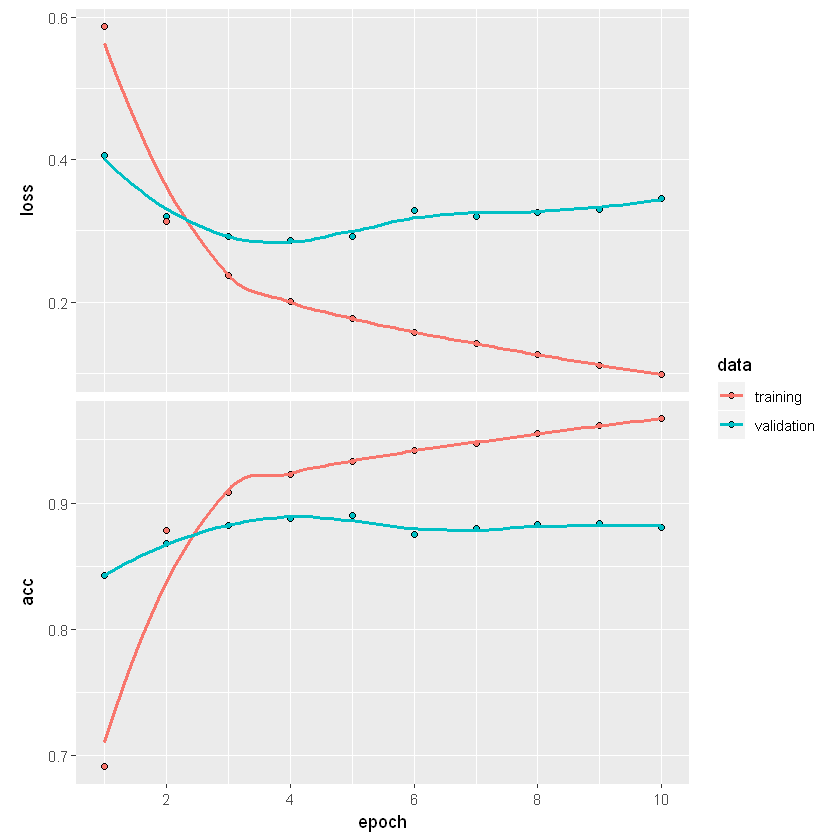

In [26]:
plot(history)